In [14]:
import math
import numpy as np
import cvxopt
from cvxopt import matrix
from cvxopt.solvers import qp

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [2]:
mu = np.array([0.05, 0.06, 0.08, 0.06])
vol = np.array([0.15, 0.2, 0.25, 0.3])
rho = np.array([[1, 0.1, 0.4, 0.5],
              [0.1, 1, 0.7, 0.4],
              [0.4, 0.7, 1, 0.8],
              [0.5, 0.4, 0.8, 1]])

1. Represent the efficient frontier

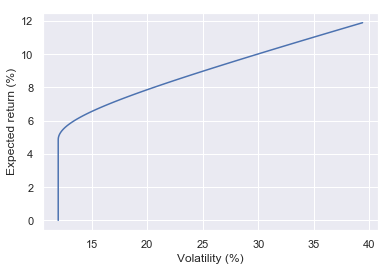

In [20]:
sigma = vol * rho * vol.reshape((vol.shape[0],1))
vec_one = np.ones(vol.shape)
vec_zero = np.zeros(vol.shape)

cvxopt.solvers.options['show_progress'] = False

P = matrix(sigma)
q = matrix(vec_zero)
A = matrix(vec_one).trans()
b = matrix(1.0)
G = -matrix(mu.reshape((mu.shape[0],1))).trans()

mu_target = np.arange(0,0.12,0.001)
s_result = np.zeros(mu_target.size)
for i in range(mu_target.size):
    temp_target = - matrix(mu_target[i])
    x = np.array(qp(P,q,G,temp_target,A,b)['x'])
    x = x.reshape((x.shape[0],))
    s_result[i] = math.sqrt(np.dot(x,np.dot(sigma,x)))

ax = plt.axes()
p = plt.plot(s_result*100,mu_target*100)
a = ax.set(xlabel='Volatility (%)',ylabel='Expected return (%)')

2. Calculate the minimum variance portfolio. What are its expected return and its volatility ?